In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import pandas_datareader.data as web
import yfinance as yf
import datetime
import seaborn as sns
import dateutil.parser
import statsmodels.api as sm
from datetime import date
from datetime import datetime
from sklearn import metrics
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing, Holt, seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse, meanabs
from pmdarima.arima import auto_arima


%matplotlib inline

Time Series Eval Metrics Method

In [2]:
def ts_eval_metrics(y_true, y_pred):
    print('Time Series Evaluation Metrics')
    print(f'MSE = {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE = {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE = {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE = {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'r2 = {metrics.r2_score(y_true, y_pred)}', end='\n\n')


In [3]:
aapl = yf.Ticker("SPY")
aapl?



### Plot an initial time series
##### Reference
##### Chaudhari, S. (2021). Stationarity in time series analysis explained using Python. Mathematics and Econometrics. https://blog.quantinsti.com/stationarity

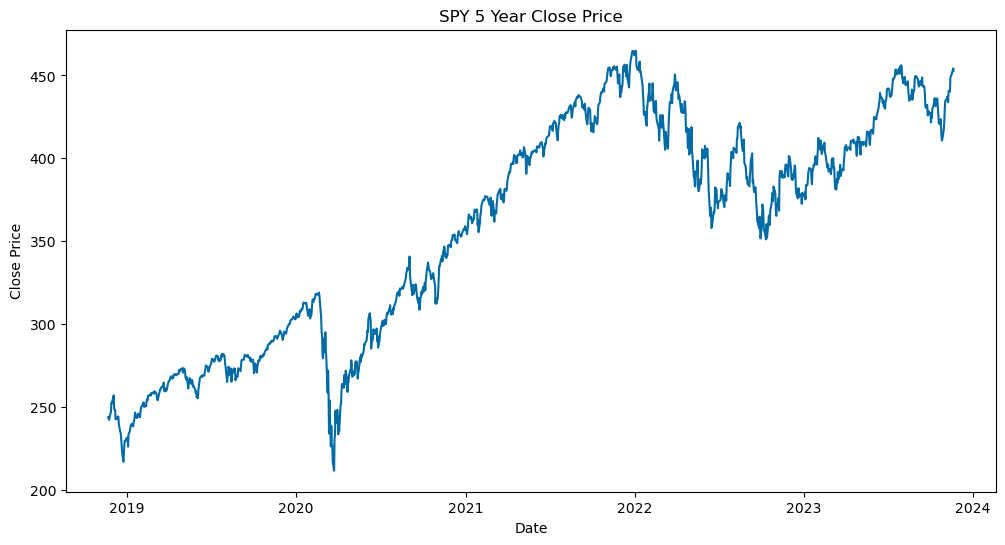

In [4]:
plt.style.use('tableau-colorblind10') #https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.figure(figsize=(12, 6))
close = aapl.history(period='5y')['Close']
plt.plot(close)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SPY 5 Year Close Price')
plt.show()

## Check stationarity

### Split Price into halves for statistical analysis

In [5]:
X = close.copy()
split = round(len(X)/2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
mean_percent_diff = (mean2 - mean1) / mean1 * 100
var1, var2 = X1.var(), X2.var()
var_percent_diff = (var2 - var1) / var1 * 100
print('mean1=%f, mean2=%3f, mean_percent_diff=%f' % (mean1, mean2, mean_percent_diff))
print('variance1=%f, variance2=%f, var_percent_diff=%f' % (var1, var2, var_percent_diff))

mean1=300.890766, mean2=415.173793, mean_percent_diff=37.981567
variance1=2047.853255, variance2=679.394353, var_percent_diff=-66.824070


### Augmented Dickey-Fuller Test
##### Check for stationarity where H0 = time series !stationary; H1 = time series = stationary
##### If p-value <= .05 or abs(test statistic)>critical value, reject H0

In [6]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -1.321228
p-value: 0.619405
Critical Values:
{'1%': -3.4356048614183443, '5%': -2.8638605461891617, '10%': -2.5680054872544145}


##### P-value > .05; therefore, time series is not stationary (as expected).
##### abs(ADF Statistic) < abs(critical value) -> fail to reject H0
##### Therefore: Time series is not stationary for p-values .01, .05, and .1

### Kwiatkowski-Phillips-Schmidt-Shin test
##### KPSS is opposite of ADF where H0 = time series = stationary; H1 = time series !stationary
##### If p-value <= .05 || abs(KPSS test statistic)>critical value -> reject H0 -> therefore, !stationary

In [7]:
result = kpss(X)
print(result)
print('KPSS Test Statistic: %.2f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[3])

(4.703880286768289, 0.01, 21, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 4.70
p-value: 0.010000
Critical Values:
{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\rkartawi\AppData\Local\Temp\ipykernel_42604\2395884048.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(X)


##### P-value < .05; therefore, not stationary

### Transform into stationary series

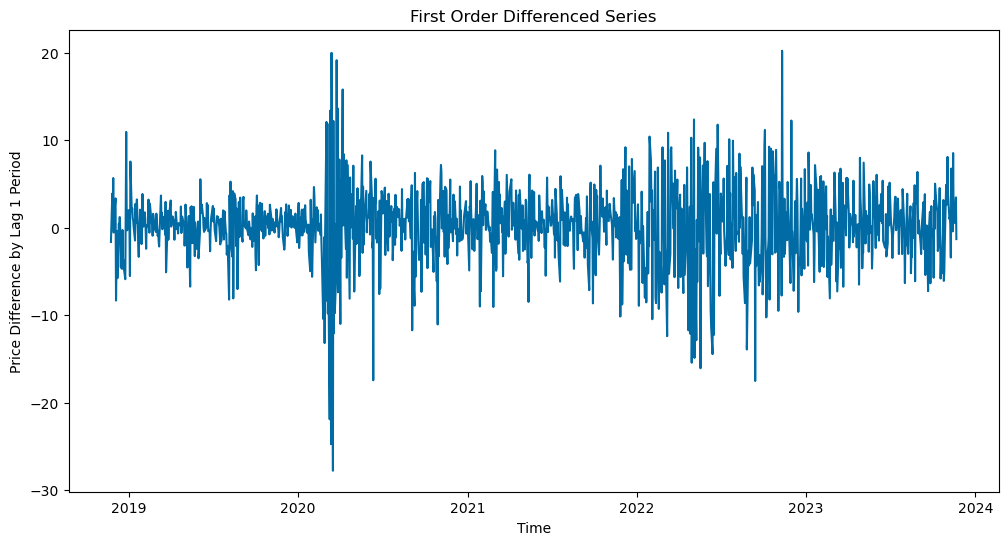

In [8]:
X['lag_1'] = X.diff() # periods=1 by default
X['lag_14'] = X.diff(periods=14) 
plt.figure(figsize=(12,6))
plt.plot(X['lag_1'])
plt.title('First Order Differenced Series')
plt.xlabel('Time')
plt.ylabel('Price Difference by Lag 1 Period')
plt.show()

### X['lag_1'], therefore, is the first-ordered differenced stationary series to use.

In [9]:
ts_lag_1 = X.lag_1.dropna()
ts_lag_14 = X.lag_14.dropna()
result = adfuller(ts_lag_1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -10.790465
p-value: 0.000000
Critical Values:
{'1%': -3.4356048614183443, '5%': -2.8638605461891617, '10%': -2.5680054872544145}


(ADF) P-value < .05; therefore, AAPL price series is a difference-stationary series.

### Smoothing Methods
##### Reference
https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/

### Triple Exponential Smoothing
##### Use because we assume these time series have level, trends, seasonality, and noise
##### https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/

In [10]:
# Using method from Brownlee, J. (2020).
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    # define model model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

## Time Series Prediction
### Data partition
#### 2 years train; last 1 year validation

In [11]:
ts_lag_1 = ts_lag_1.asfreq('D')
ts_lag_1 = ts_lag_1.ffill()

past_year = ts_lag_1.iloc[-252:] # Typically 252 trading days per year
before_past_year = ts_lag_1.iloc[:-len(past_year)] # Beginning of selected time series until before 'past_year'

In [12]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]
close_valid = close.iloc[-252:]

## Simple Exponential forecaster
### Plot an initial time series
##### Reference: Module 1

In [13]:
# Forecast 12 months ahead
ses_model = SimpleExpSmoothing(close_train).fit()

ses_pred = ses_model.forecast(steps=len(close_valid))
ses_eval_metrics = ts_eval_metrics(close_valid, ses_pred)

Time Series Evaluation Metrics
MSE = 1262.6671748773808
MAE = 29.117683290006887
RMSE = 35.53402840767397
MAPE = 0.06745570708401717
r2 = -1.4440722721657266



C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


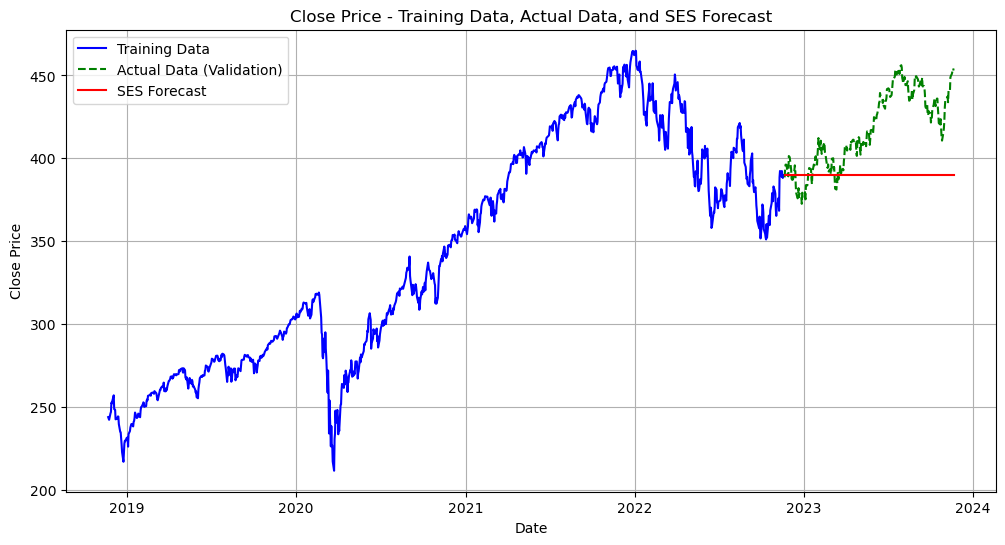

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, ses_pred, label='SES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and SES Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
#### WORKING IN PROGRESS to be investigate ######

# #impute
close = close.asfreq('D')
close = close.ffill()

## Decomposition of Raw Values

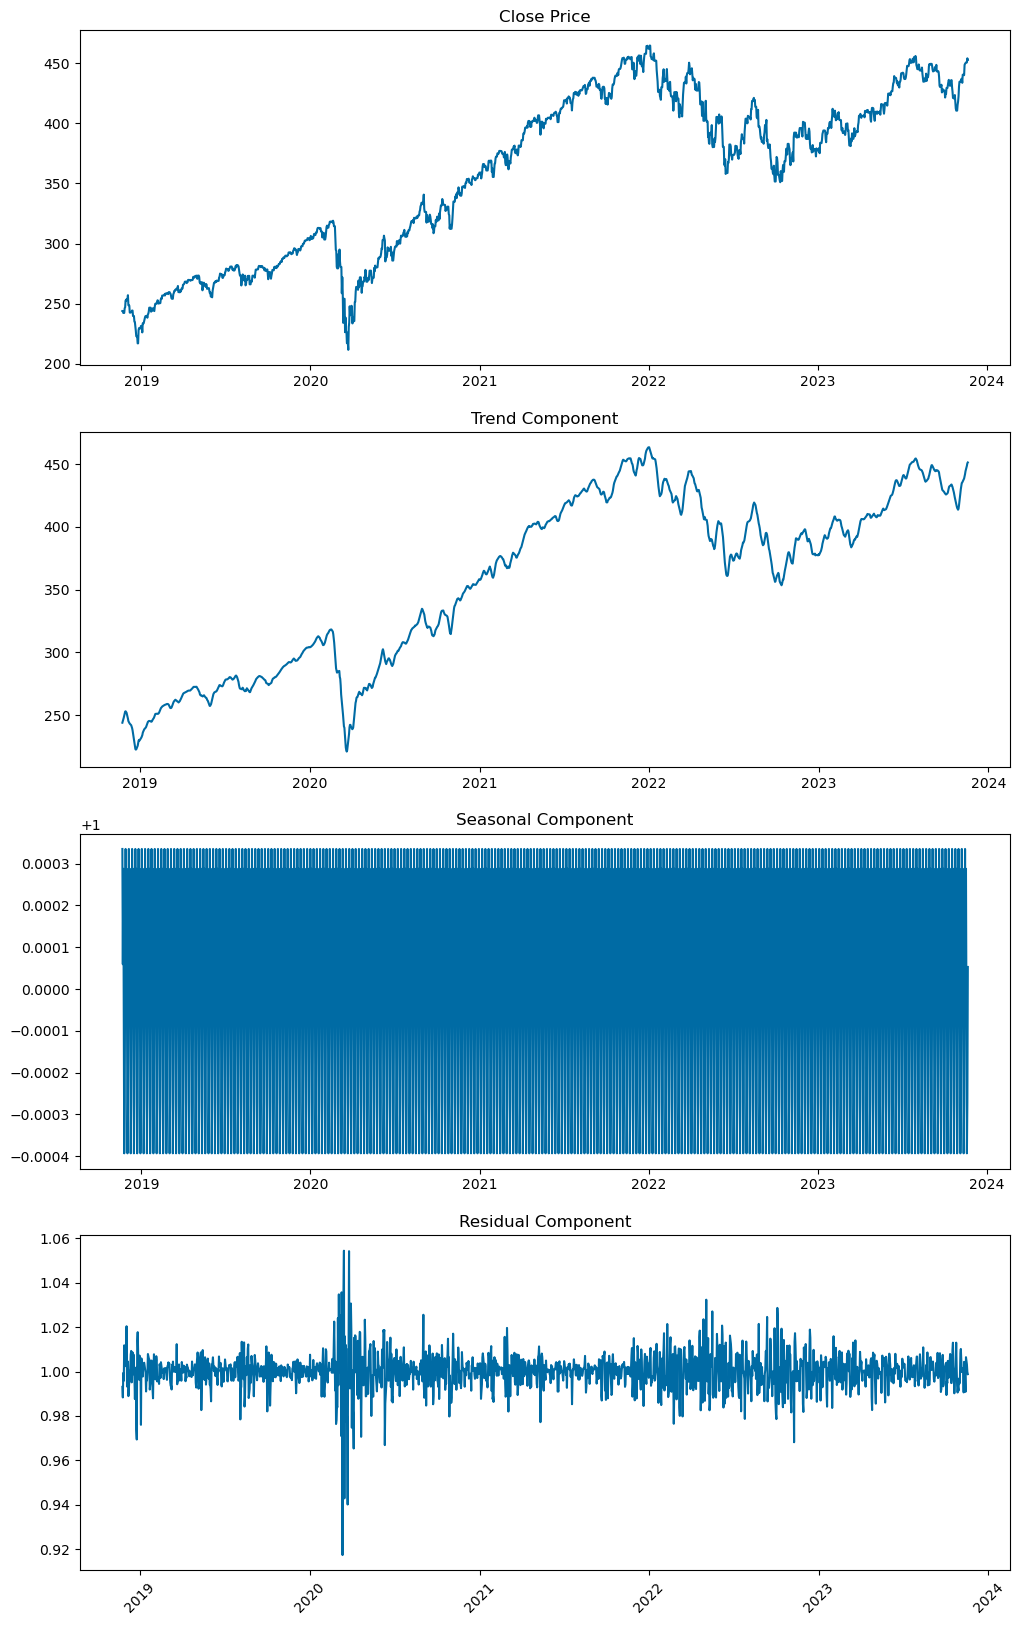

In [16]:
decomposition = seasonal_decompose(close, model='multiplicative')
#decomposition.plot()

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, axs = plt.subplots(4)
fig.set_figheight(20)
fig.set_figwidth(12)
plt.xticks(rotation=45)
axs[0].title.set_text('Close Price')
axs[1].title.set_text('Trend Component')
axs[2].title.set_text('Seasonal Component')
axs[3].title.set_text('Residual Component')
axs[0].plot(close)
axs[1].plot(trend)
axs[2].plot(seasonal)
axs[3].plot(residual)

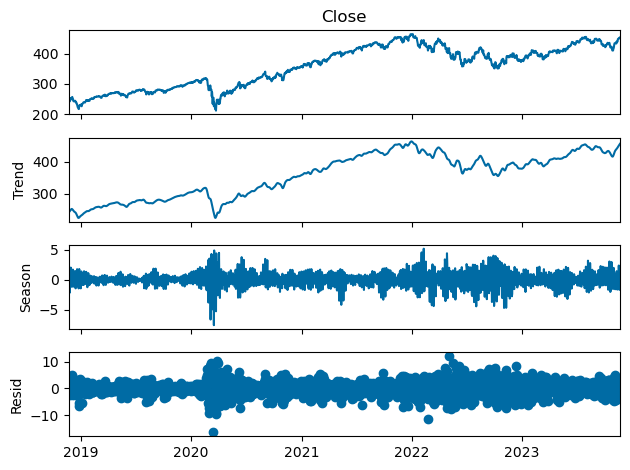

In [17]:
stl = STL(close).fit().plot()


### Autocorrelation - Raw Values

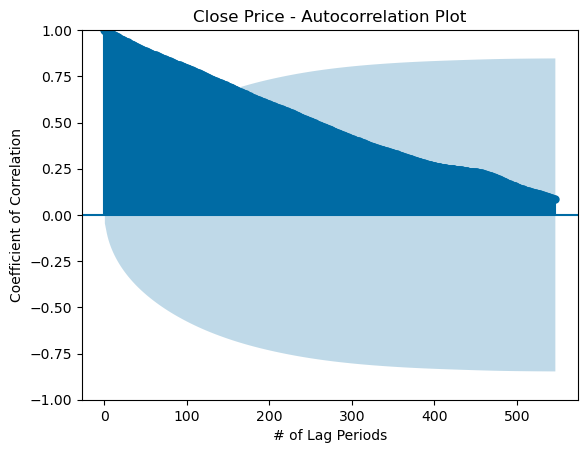

In [18]:
plot_acf(close, lags=546)  # Adjust the number of lags as needed
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Autocorrelation Plot')
plt.show()

### Partial Autocorrelation Plot - Raw Values

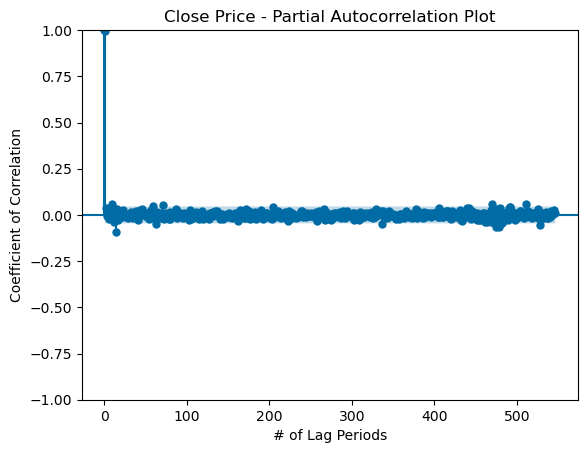

In [19]:
plot_pacf(close, lags=546)
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Partial Autocorrelation Plot')
plt.show()

### Therefore, based on PACF plot, we may want to do AR model with lags 1, 2 ~415, ~485, ~510.

## Lag_1 Decomposition

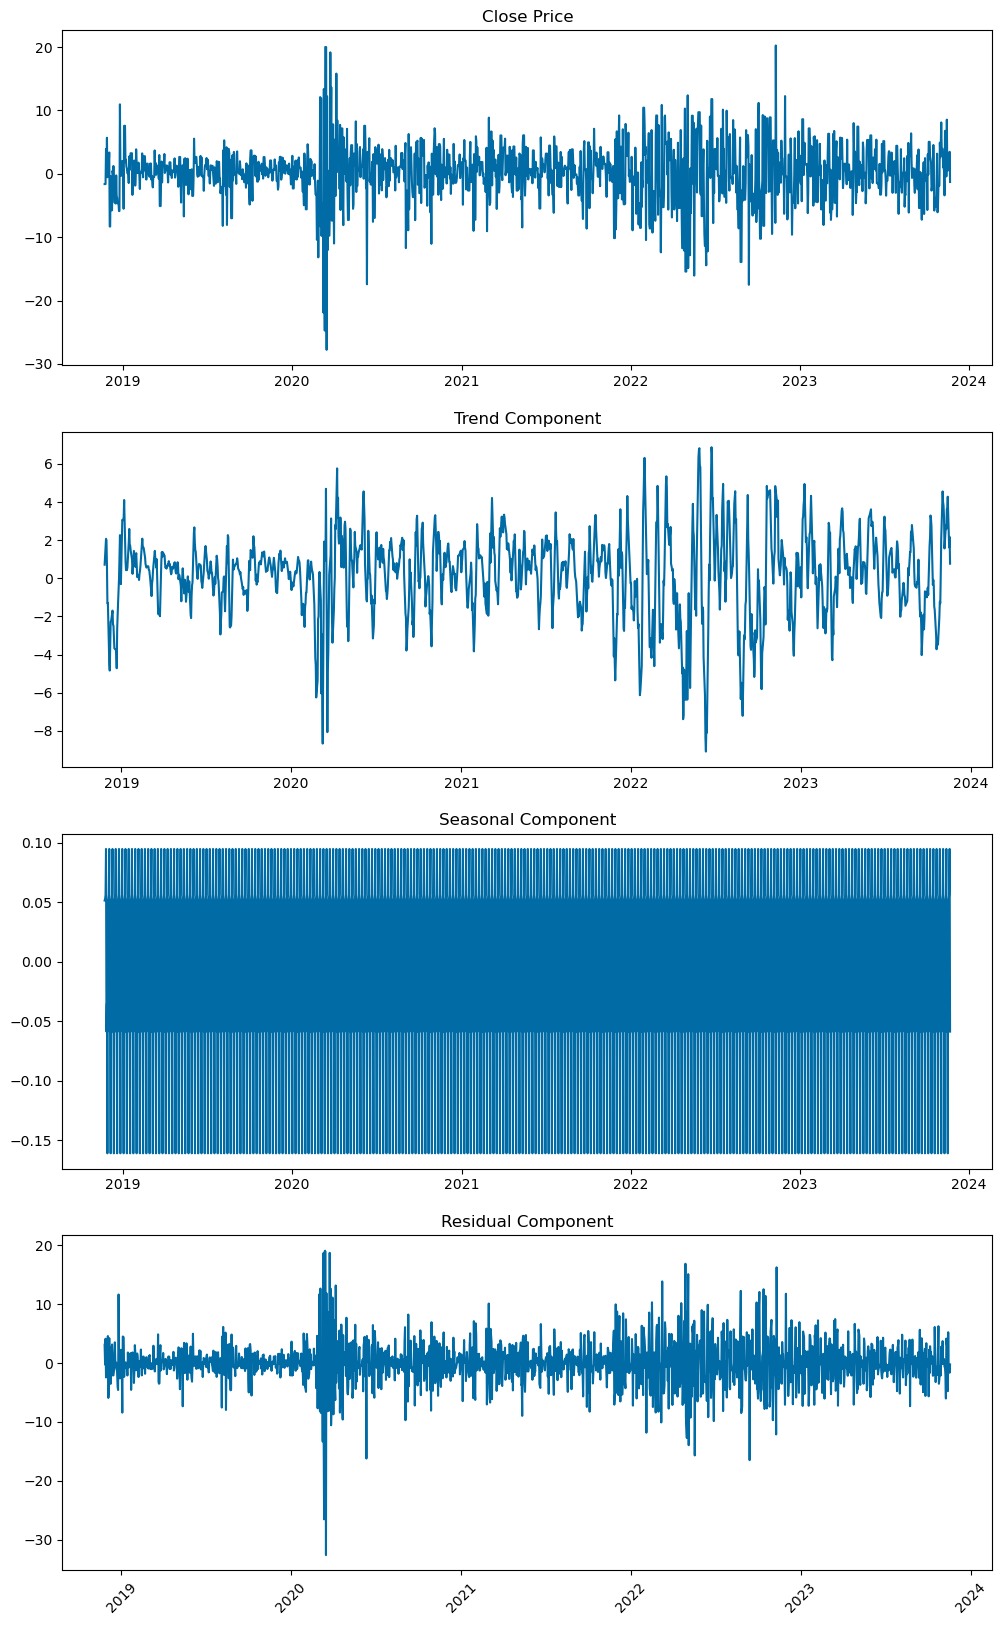

In [20]:
decomposition_lag_1 = seasonal_decompose(ts_lag_1, model='additive')
#decomposition.plot()

trend_lag_1 = decomposition_lag_1.trend
seasonal_lag_1 = decomposition_lag_1.seasonal
residual_lag_1 = decomposition_lag_1.resid

fig, axs = plt.subplots(4)
fig.set_figheight(20)
fig.set_figwidth(12)
plt.xticks(rotation=45)
axs[0].title.set_text('Close Price')
axs[1].title.set_text('Trend Component')
axs[2].title.set_text('Seasonal Component')
axs[3].title.set_text('Residual Component')
axs[0].plot(ts_lag_1)
axs[1].plot(trend_lag_1)
axs[2].plot(seasonal_lag_1)
axs[3].plot(residual_lag_1)

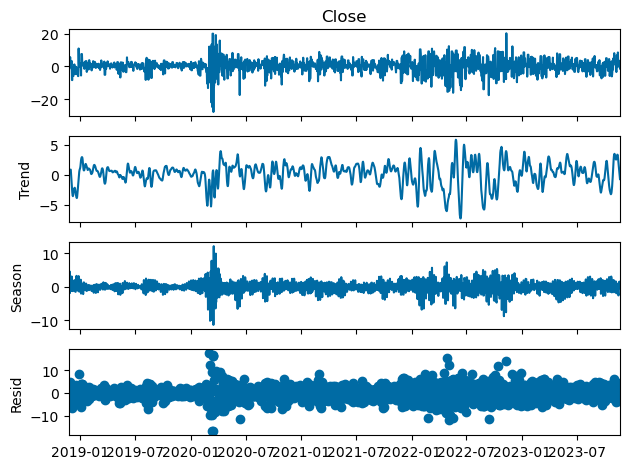

In [21]:
stl = STL(ts_lag_1).fit().plot()


# ARIMA Parameter Selection
##### Reference: Shmueli, G. (2016). ARIMA models [Youtube Video]. https://www.youtube.com/watch?v=0xHf-SJ9Z9U&list=PLoK4oIB1jeK0LHLbZW3DTT05e4srDYxFq&index=29

### ACF on lag_1 period

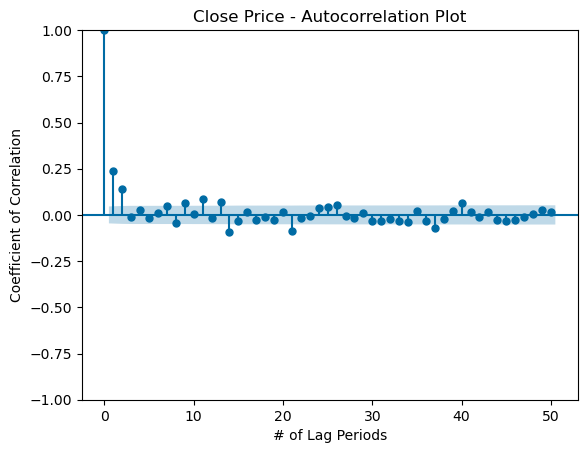

In [22]:
plot_acf(ts_lag_1, lags=50)  # Adjust the number of lags as needed
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Autocorrelation Plot')
plt.show()

### Therefore, based on ACF plot, we may want to do MA at 0, 1, 2, 11, 13, 14, 21, 37, 40.

### Plot PACF on lag_1 period

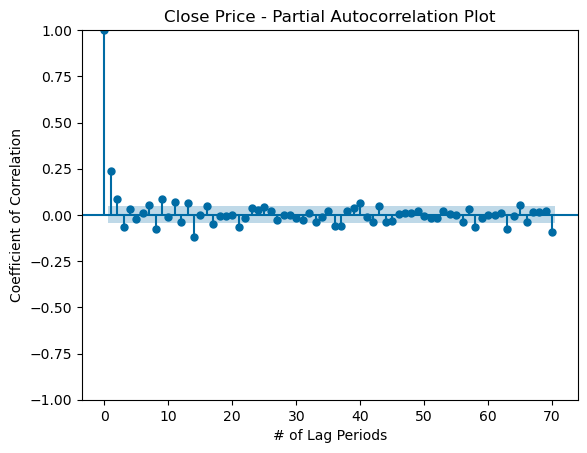

In [23]:
plot_pacf(ts_lag_1, lags=70)
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Partial Autocorrelation Plot')
plt.show()

### Therefore, based on PACF plot, we may want to do AR at 1, 2, 3, 8, 9, 11, 14, and 21, 58, 63, 70.

In [24]:
# Reference: ritvikmath (2020, Oct 7). Time series model selection (AIC & BIC): Time series talk [YouTube]. 
# https://www.youtube.com/watch?v=McEN54l3EPU

ar_orders = [1, 2, 3, 8, 9, 11, 14, 21]#, 58, 63]#, 70] # based on PACF
#ar_orders = [58, 63]#, 70] # based on PACF # attempting higher order from PACF
ma_orders = [1, 2, 11, 13, 14, 21] # based on ACF
fitted_model_dict = {}
for i, ar_order in enumerate(ar_orders):
    ar_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(ar_order,1,1),trend='n') #import statsmodels.api as sm for ARIMA
    ar_model_fit = ar_model.fit()
    fitted_model_dict[ar_order] = ar_model_fit
for ar_order in ar_orders:
    print('AIC for AR(%s): %s' %(ar_order, fitted_model_dict[ar_order].aic))
    print('BIC for AR(%s): %s' %(ar_order, fitted_model_dict[ar_order].bic))
    print('\n')
    

C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkartawi\AppData\L

AIC for AR(1): 10453.771608364894
BIC for AR(1): 10470.297969876796


AIC for AR(2): 10941.528350528813
BIC for AR(2): 10963.56349921135


AIC for AR(3): 10436.523145995929
BIC for AR(3): 10464.0670818491


AIC for AR(8): 10428.187363916086
BIC for AR(8): 10483.275235622428


AIC for AR(9): 10416.539324921127
BIC for AR(9): 10477.135983798104


AIC for AR(11): 10411.747797956077
BIC for AR(11): 10483.362031174323


AIC for AR(14): 10381.122298202705
BIC for AR(14): 10469.262892932853


AIC for AR(21): 10378.622636713979
BIC for AR(21): 10505.324741638568




### Select AR(14) due to lowest AIC and BIC

### Rerun with AR(14) as default and iterate through different MA orders based on ACF

In [25]:
# Reference: ritvikmath (2020, Oct 7). Time series model selection (AIC & BIC): Time series talk [YouTube]. 
# https://www.youtube.com/watch?v=McEN54l3EPU

#ar_orders = [1, 2, 3, 8, 9, 11, 14, 21]
ar_orders = [0, 1, 2, 11, 13, 14, 21, 37, 40] #actually MA orders, but using same var name for simplicity
fitted_model_dict = {}
for i, ar_order in enumerate(ar_orders):
    ar_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(14,1,ar_order)) #import statsmodels.api as sm for ARIMA
    ar_model_fit = ar_model.fit()
    fitted_model_dict[ar_order] = ar_model_fit
for ar_order in ar_orders:
    print('AIC for MA(%s): %s' %(ar_order, fitted_model_dict[ar_order].aic))
    print('BIC for MA(%s): %s' %(ar_order, fitted_model_dict[ar_order].bic))
    print('\n')
    

C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkartawi\AppData\L

AIC for MA(0): 10486.44290325424
BIC for MA(0): 10569.074710813753


AIC for MA(1): 10381.122298202705
BIC for MA(1): 10469.262892932853


AIC for MA(2): 10412.00073041817
BIC for MA(2): 10505.650112318954


AIC for MA(11): 10371.965421768033
BIC for MA(11): 10515.193888204523


AIC for MA(13): 10370.22206645816
BIC for MA(13): 10524.46810723592


AIC for MA(14): 10372.996254998416
BIC for MA(14): 10532.75108294681


AIC for MA(21): 10375.341166327085
BIC for MA(21): 10573.65750446992


AIC for MA(37): 10364.459606401053
BIC for MA(37): 10650.916539274036


AIC for MA(40): 10367.814927423275
BIC for MA(40): 10670.79822180816




### AIC and BIC minimization suggest order=(14,1,1) is the optimal 3-tuple

### Measure error statistics on validation set

In [26]:
arima_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(14,1,1)).fit() #import statsmodels.api as sm for ARIMA

arima_pred = arima_model.forecast(steps=len(close_valid))
arima_metrics = ts_eval_metrics(close_valid, arima_pred)

Time Series Evaluation Metrics
MSE = 174282.60528480122
MAE = 416.85279820612396
RMSE = 417.4716820154407
MAPE = 0.9995280973687054
r2 = -336.3488212669757



### Interpretation: Even with minimum AIC and BIC, ARIMA optimal pdq based on ACF and PACF performs very poorly

## Attempt: Find optimal AES model parameters

In [27]:
#close_train = pd.DataFrame(close_train)
#close_train.reset_index(inplace=True)

In [28]:
#close_train.index

In [29]:
# Reference: https://www.statsmodels.org/stable/generated/
# statsmodels.tsa.holtwinters.ExponentialSmoothing.html#statsmodels.tsa.holtwinters.ExponentialSmoothing

aes_param_trend = ['add', 'mul', 'additive', 'multiplicative', None]
aes_param_damped_trend = [True, False]
aes_param_seasonal = ['add', 'mul', 'additive', 'multiplicative', None]
aes_param_seasonal_periods = [2, 3, 8, 9, 11, 14, 21, 58, 59, 60, 61, 62, 63, 64, 65, 70] # Informed by PACF
aes_param_initial_method = [None, 'estimated', 'heuristic', 'legacy-heuristic']

fit_param_smoothing_level = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_smoothing_trend = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_smoothing_seasonal = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_damping_trend = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_optimzied = [True, False]
fit_method = ['L-BFGS-B', 'TNC', 'SLSQP', 'Powell', 'trust-constr', 'least_square']

fitted_model_dict = {}

### Searching for ideal seasonal period parameter

In [30]:
for i in aes_param_seasonal_periods:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=True, #True, False
                                     seasonal= 'mul', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= i, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Seasonal Period %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)


C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and

Results for Seasonal Period 2
AIC = 3548.873663880818
BIC = 3583.269825335436
Time Series Evaluation Metrics
MSE = 1275.6186122256952
MAE = 29.306675679145204
RMSE = 35.71580339605558
MAPE = 0.06790008755172591
r2 = -1.4691416249908533

Results for Seasonal Period 3
AIC = 3862.164328301594
BIC = 3901.4742271068717
Time Series Evaluation Metrics
MSE = 1163.5838813027383
MAE = 27.764332553143838
RMSE = 34.11134534583382
MAPE = 0.06431742987355492
r2 = -1.2522824361116158

Results for Seasonal Period 8
AIC = 4436.938399142829
BIC = 4500.816984701405
Time Series Evaluation Metrics
MSE = 1892.1772418053126
MAE = 40.797725247290956
RMSE = 43.49916369087241
MAPE = 0.09801599142519817
r2 = -2.662578724412069



C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer 

Results for Seasonal Period 9
AIC = 4451.13618377806
BIC = 4519.928506687295
Time Series Evaluation Metrics
MSE = 2360.7548365626385
MAE = 45.520694922191616
RMSE = 48.58759961721343
MAPE = 0.10915979167631315
r2 = -3.569577440693502

Results for Seasonal Period 11
AIC = 4540.3733246058955
BIC = 4618.9931222164505
Time Series Evaluation Metrics
MSE = 3429.6285732567553
MAE = 55.18429342324768
RMSE = 58.56303077246562
MAPE = 0.13184490064923224
r2 = -5.638534893835463

Results for Seasonal Period 14
AIC = 4582.763147815571
BIC = 4676.124157478105
Time Series Evaluation Metrics
MSE = 5369.360470148306
MAE = 68.93858902079957
RMSE = 73.2759201248835
MAPE = 0.16420423650297822
r2 = -9.393162430651296



C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer 

Results for Seasonal Period 21
AIC = 4616.536487816207
BIC = 4744.293658933359
Time Series Evaluation Metrics
MSE = 6563.083551969155
MAE = 76.1545797221841
RMSE = 81.01286041098139
MAPE = 0.181180590407791
r2 = -11.703783584801347

Results for Seasonal Period 58
AIC = 4791.886108815992
BIC = 5101.451561907552
Time Series Evaluation Metrics
MSE = 15431.150170451212
MAE = 116.55015845563425
RMSE = 124.22218067016539
MAPE = 0.27656669449446236
r2 = -28.869190400778233



C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer 

Results for Seasonal Period 59
AIC = 4798.014820067011
BIC = 5112.494010509231
Time Series Evaluation Metrics
MSE = 8730.594563981731
MAE = 87.53206997996668
RMSE = 93.43765067670383
MAPE = 0.20788667759727464
r2 = -15.89931006198902

Results for Seasonal Period 60
AIC = 4793.923596139976
BIC = 5113.3165239328555
Time Series Evaluation Metrics
MSE = 3998.0091457209596
MAE = 59.08471826468894
RMSE = 63.22981215946288
MAPE = 0.1407979630771394
r2 = -6.738716497378256

Results for Seasonal Period 61
AIC = 4522.999411468838
BIC = 4847.306076612377
Time Series Evaluation Metrics
MSE = 1419.3614062634247
MAE = 31.36593787516659
RMSE = 37.674413150882984
MAPE = 0.07278136873395302
r2 = -1.7473762890584927

Results for Seasonal Period 62
AIC = 4795.459417413795
BIC = 5124.679819907993
Time Series Evaluation Metrics
MSE = 12179.4711393871
MAE = 103.82539033317377
RMSE = 110.36064126031118
MAPE = 0.24663926536319267
r2 = -22.57510220720633



C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer 

Results for Seasonal Period 63
AIC = 4775.626197561515
BIC = 5109.760337406374
Time Series Evaluation Metrics
MSE = 11113.907082487476
MAE = 98.53379883823773
RMSE = 105.42251696145125
MAPE = 0.23382609629151266
r2 = -20.51255111100182

Results for Seasonal Period 64
AIC = 4724.843585836367
BIC = 5063.891463031886
Time Series Evaluation Metrics
MSE = 5023.247298976536
MAE = 66.31805767932654
RMSE = 70.87487071576594
MAPE = 0.15778315906064638
r2 = -8.723211059836242

Results for Seasonal Period 65
AIC = 4721.402646474531
BIC = 5065.364261020709
Time Series Evaluation Metrics
MSE = 2977.0611627713365
MAE = 51.01314089125103
RMSE = 54.56245194977345
MAPE = 0.12180469885028168
r2 = -4.762526170982054

Results for Seasonal Period 70
AIC = 4790.106410209795
BIC = 5158.636711509272
Time Series Evaluation Metrics
MSE = 10747.574040926465
MAE = 97.10722117735817
RMSE = 103.67050709303233
MAPE = 0.23058111445660553
r2 = -19.80346129931463



C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer 

### Seasonal Periods at 2, 3, and 60 appear to be locally optimal candidate parameter values, but accounting for AIC and BIC, Seasonal Period 2 or 3 may be ideal.

### Searching for ideal seasonal parameter

In [31]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_seasonal:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=False, #True, False
                                     seasonal= i, # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Seasonal %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)


Results for Seasonal add
AIC = 3897.5118190570133
BIC = 3931.907980511631
Time Series Evaluation Metrics
MSE = 493.0097664452462
MAE = 17.813096742576764
RMSE = 22.203823239371328
MAPE = 0.04288946723707599
r2 = 0.04570933334610405

Results for Seasonal mul
AIC = 3895.071155642909
BIC = 3929.467317097527
Time Series Evaluation Metrics
MSE = 641.2802560013419
MAE = 20.52228776191416
RMSE = 25.323511920769242
MAPE = 0.049266860850941584
r2 = -0.2412893306840136

Results for Seasonal additive
AIC = 3897.5118190570133
BIC = 3931.907980511631
Time Series Evaluation Metrics
MSE = 493.0097664452462
MAE = 17.813096742576764
RMSE = 22.203823239371328
MAPE = 0.04288946723707599
r2 = 0.04570933334610405

Results for Seasonal multiplicative
AIC = 3895.071155642909
BIC = 3929.467317097527
Time Series Evaluation Metrics
MSE = 641.2802560013419
MAE = 20.52228776191416
RMSE = 25.323511920769242
MAPE = 0.049266860850941584
r2 = -0.2412893306840136

Results for Seasonal None
AIC = 4656.873151106059
BIC 

C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and

### Validation statistics suggest additive seasonality is optimal

### Searching for ideal trend parameter

In [33]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_trend:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend=i, # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=True, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Trend %s' % (i))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and

Results for Trend add
AIC = 3861.9357587868667
BIC = 3901.245657592144
Time Series Evaluation Metrics
MSE = 1179.7759825626106
MAE = 27.982909918826376
RMSE = 34.347867219997966
MAPE = 0.06482372782078079
r2 = -1.2836245557966364

Results for Trend mul
AIC = 3907.1425388060893
BIC = 3946.452437611367
Time Series Evaluation Metrics
MSE = 200.09001730655817
MAE = 11.548723111761479
RMSE = 14.145317858095595
MAPE = 0.027495499996151637
r2 = 0.612697254695316

Results for Trend additive
AIC = 3861.9357587868667
BIC = 3901.245657592144
Time Series Evaluation Metrics
MSE = 1179.7759825626106
MAE = 27.982909918826376
RMSE = 34.347867219997966
MAPE = 0.06482372782078079
r2 = -1.2836245557966364

Results for Trend multiplicative
AIC = 3907.1425388060893
BIC = 3946.452437611367
Time Series Evaluation Metrics
MSE = 200.09001730655817
MAE = 11.548723111761479
RMSE = 14.145317858095595
MAPE = 0.027495499996151637
r2 = 0.612697254695316



ValueError: Can only dampen the trend component

### Validation statistics suggest multiplicative trend is optimal

### Searching for ideal aes_param_damped_trend parameter

In [34]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_damped_trend:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=i, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Damped Trend %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

Results for Damped Trend True
AIC = 3888.823489372486
BIC = 3928.1333881777637
Time Series Evaluation Metrics
MSE = 255.05787641926267
MAE = 13.219543911850307
RMSE = 15.970531500838119
MAPE = 0.03141174543948013
r2 = 0.5062991293692816

Results for Damped Trend False
AIC = 3897.512189137692
BIC = 3931.90835059231
Time Series Evaluation Metrics
MSE = 493.0099071753142
MAE = 17.813099462952685
RMSE = 22.20382640842146
MAPE = 0.042889473677766896
r2 = 0.045709060943000646



C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and

### Validation statistics suggest trend should be damped.

### Searching for optimal initialization method

In [35]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_initial_method:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='add', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=False, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method=i
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Initialization Method %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and

Results for Initialization Method None
AIC = 3911.9236110508987
BIC = 3946.3197725055165
Time Series Evaluation Metrics
MSE = 261.2772305342452
MAE = 13.030993054151207
RMSE = 16.164072213840335
MAPE = 0.03157639981493277
r2 = 0.4942606830980505

Results for Initialization Method estimated
AIC = 3898.736994067869
BIC = 3933.133155522487
Time Series Evaluation Metrics
MSE = 279.24558632290257
MAE = 13.446121964116331
RMSE = 16.71064290573234
MAPE = 0.03257843962255888
r2 = 0.45948036962096117

Results for Initialization Method heuristic
AIC = 3899.6783704563713
BIC = 3934.074531910989
Time Series Evaluation Metrics
MSE = 282.1891514235496
MAE = 13.513218181247085
RMSE = 16.798486581342665
MAPE = 0.03274004315684102
r2 = 0.4537826798520759

Results for Initialization Method legacy-heuristic
AIC = 3911.9236110508987
BIC = 3946.3197725055165
Time Series Evaluation Metrics
MSE = 261.2772305342452
MAE = 13.030993054151207
RMSE = 16.164072213840335
MAPE = 0.03157639981493277
r2 = 0.4942606830

C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer 

### Validation statistics suggest initialization should be heuristic.

### Final pre-fit Advanced Exponential Smoothing Model w/ Parameters

In [36]:
aes_model = ExponentialSmoothing(close_train, 
                                 trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                 damped_trend=True, #True, False
                                 seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                 seasonal_periods= 3, 
                                 initialization_method='heuristic') #'estimated', 'heuristic', 'legacy-heuristic'

aes_model = aes_model.fit(smoothing_level=.1, 
                          smoothing_trend=.1,
                          #smoothing_seasonal=.1,
                          #damping_trend=.002
                         )

aes_pred = aes_model.forecast(steps=len(close_valid))
print('AIC = %s' %(aes_model.aic))
print('BIC = %s' %(aes_model.bic))
aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)
print(aes_eval_metrics)

C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


AIC = 3888.823416069596
BIC = 3928.1333148748736
Time Series Evaluation Metrics
MSE = 255.05799661650354
MAE = 13.219546377266004
RMSE = 15.97053526393225
MAPE = 0.031411751126168286
r2 = 0.5062988967103914

None


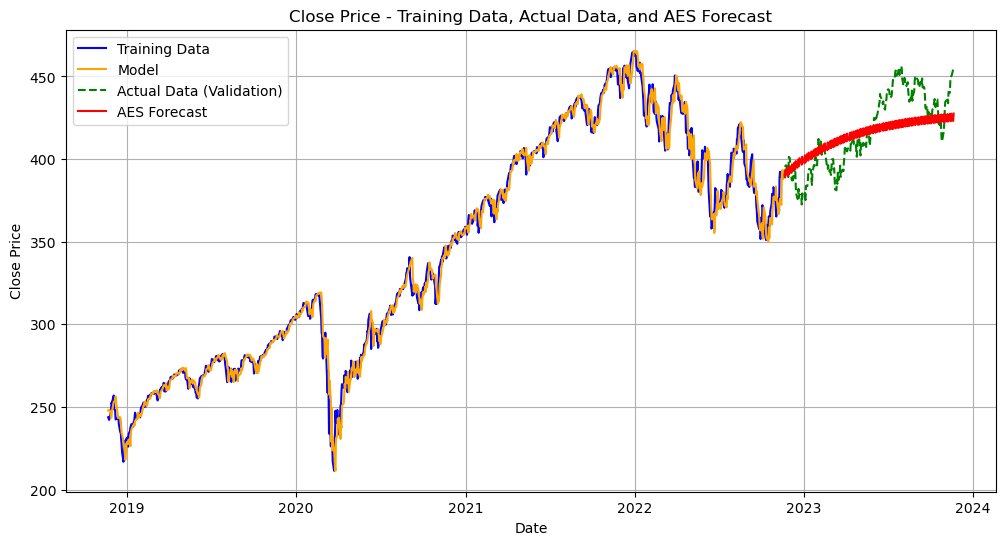

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(aes_model.fittedvalues, label="Model", color = 'orange')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, aes_pred, label='AES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and AES Forecast')
plt.legend()
plt.grid(True)
plt.show()

### Replicate the above, but with seasonal_periods=2 for lower AIC and BIC

In [38]:
aes_model = ExponentialSmoothing(close_train, 
                                 trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                 damped_trend=True, #True, False
                                 seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                 seasonal_periods= 2, 
                                 initialization_method='heuristic') #'estimated', 'heuristic', 'legacy-heuristic'

aes_model = aes_model.fit(smoothing_level=.1, 
                          smoothing_trend=.1,
                          #smoothing_seasonal=.1,
                          #damping_trend=.002
                         )

aes_pred = aes_model.forecast(steps=len(close_valid))
print('AIC = %s' %(aes_model.aic))
print('BIC = %s' %(aes_model.bic))
aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)
print(aes_eval_metrics)

AIC = 3561.1970479917545
BIC = 3595.5932094463724
Time Series Evaluation Metrics
MSE = 584.5005639245331
MAE = 19.278572281155462
RMSE = 24.17644647016044
MAPE = 0.04474055657252127
r2 = -0.1313841444337156

None


C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


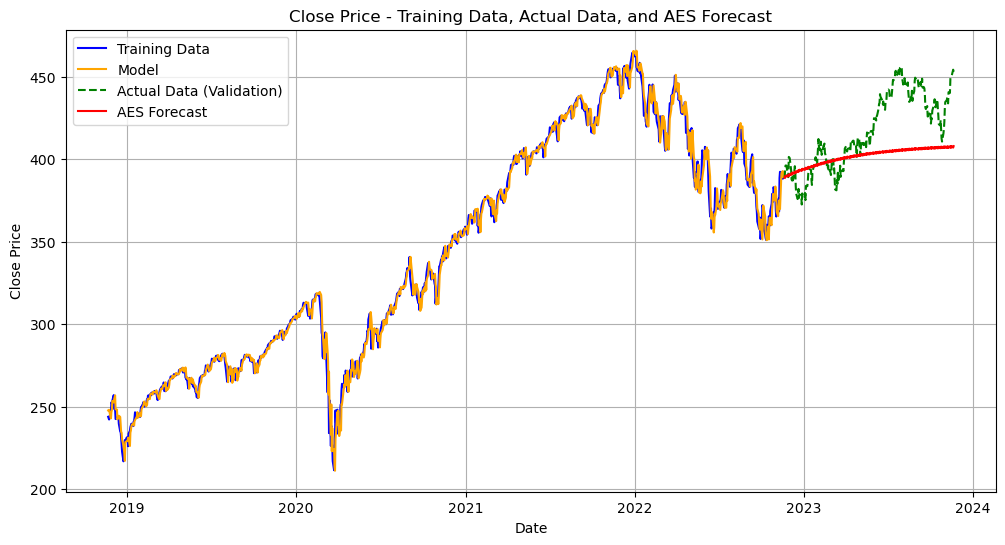

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(aes_model.fittedvalues, label="Model", color = 'orange')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, aes_pred, label='AES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and AES Forecast')
plt.legend()
plt.grid(True)
plt.show()

## Autoregression Integrated Moving Average (ARIMA)
##### Reference:
##### Brownlee, J. (2020). How to create an ARIMA model for time series forecasting in Python. Machine Learning Mastery. https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python

In [40]:
# Auto regression integrated moving average; Find best (p,d,q) by using auto_arima function
# p = number of lag observations, lag order
# d = number of raw observations differenced, degree of differencing
# q = size of moving average window, order of moving average
# auto_arima_model = auto_arima(close_train, d=2, seasonal=True, stepwise=True, trace=True)
# auto_arima_model.summary()
# arima_pred = auto_arima_model.predict(n_periods=len(close_valid))
close_train = close_train.asfreq('D')
arima_model = sm.tsa.ARIMA(close_train, order=(14,1,0)).fit() #use '2' for quadratic trend
print(arima_model.summary())
arima_pred = arima_model.forecast(steps=len(close_valid))

# arima_eval_metrics = ts_eval_metrics(close_valid, arima_pred)
# print(arima_eval_metrics)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1459
Model:                ARIMA(14, 1, 0)   Log Likelihood               -2939.214
Date:                Tue, 21 Nov 2023   AIC                           5908.429
Time:                        10:30:39   BIC                           5987.701
Sample:                    11-21-2018   HQIC                          5938.003
                         - 11-18-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1334      0.031     -4.252      0.000      -0.195      -0.072
ar.L2         -0.1100      0.031     -3.522      0.000      -0.171      -0.049
ar.L3          0.2008      0.033      6.083      0.0

In [41]:
# auto_arima_model.plot_diagnostics(figsize=(12, 8))
# arima_pred.head

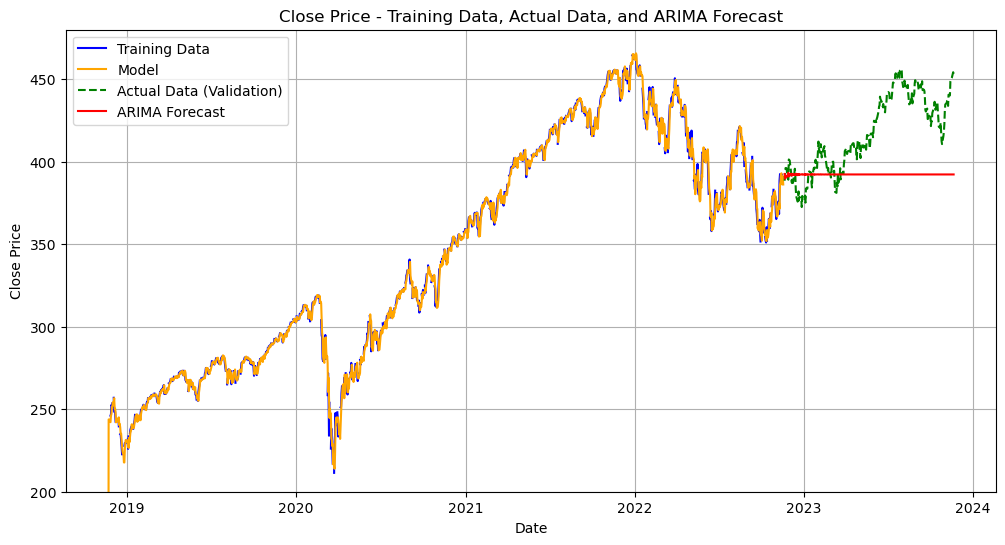

In [42]:
# plt.plot(close_valid.index, arima_pred, label="Predicted", color='red')
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.set_ylim([200, 480])
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(arima_model.fittedvalues, label="Model", color = 'orange') # turn off it doesnt work
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, arima_pred, label='ARIMA Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

### Binary Field on positive/ negative of Open - Close

#### Data Stationary

In [43]:
hist = aapl.history(period = '1y')
hist_lag_1 = hist.diff()
# hist_lag_1 = hist.diff(periods=14)
# hist_lag_1 = hist.shift(2)
hist_lag_1 = hist_lag_1.dropna()

#### Add new columns

In [44]:
hist_lag_1['open_close'] = hist_lag_1['Close'] - hist_lag_1['Open']
hist_lag_1['positive'] = np.where(hist_lag_1['open_close'] >= 0, 1, 0)
hist_lag_1['high_low'] = hist_lag_1['High'] - hist_lag_1['Low']

# positive = hist_lag_1['positive']
# plt.figure(figsize=(14, 6))
# plt.plot(positive)
# plt.xlabel('Date')
# plt.ylabel('Positive')
# plt.title('SPY 150 days up/down')
# plt.show()
# hist_lag_1.describe()

#### Data Partition

In [45]:
X = hist_lag_1.drop(['positive'], axis =1)
# X = hist_lag_1[['open_close','Volume','high_low']]
y = hist_lag_1['positive']

end_train_index = 200
X_train = X.iloc[:end_train_index]
X_valid = X.iloc[end_train_index:]

y_train = y.iloc[:end_train_index]
y_valid = y.iloc[end_train_index:]


#### Logistics Regression

Accuracy: 64.71%
Sensitivity: 0.68
Specificity: 0.62


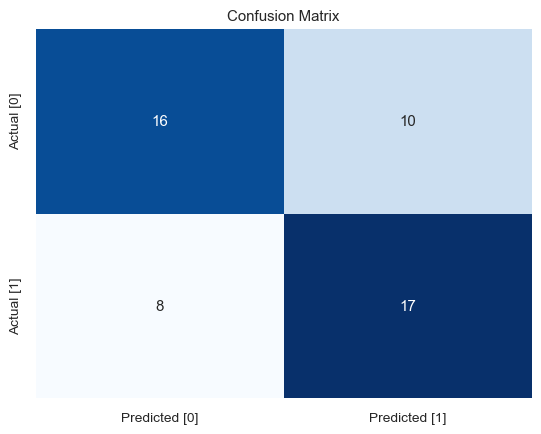

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns


logreg_model = LogisticRegression()
logreg_model.fit(X_train,y_train)

logreg_pred = logreg_model.predict(X_valid)


#### Logistic Regression Performance

In [ ]:

logreg_coef = logreg_model.coef_
logreg_intercept = logreg_model.intercept_

logreg_accuracy = accuracy_score(y_valid, logreg_pred)
logreg_cm = confusion_matrix(y_valid, logreg_pred)
# logreg_classrpt = classification_report(y_valid, logreg_pred)
tn, fp, fn, tp = logreg_cm.ravel()
logreg_sensi = tp / (tp + fn)
logreg_speci = tn / (tn + fp)

print(f'Accuracy: {logreg_accuracy:.2%}')
print(f'Sensitivity: {logreg_sensi:.2f}')
print(f'Specificity: {logreg_speci:.2f}')

sns.set(font_scale=0.9)
sns.heatmap(logreg_cm, annot=True, cmap='Blues', cbar=False,
            xticklabels=['Predicted [0]', 'Predicted [1]'],
            yticklabels=['Actual [0]', 'Actual [1]'])
plt.title('Confusion Matrix')
plt.show()

In [47]:
yf.pdr_override()

y_symbols = ['^GSPC', 'ES=F', 'NQ=F', 'YM=F', '^RUT', '^DJT', '^GDAXI', '^N225', '^SSMI', '^STOXX50E', '^FCHI', '^GSPTSE', '^HSI', '000001.SS', '^KS11', '^NSEI', '^AXJO']
stocks = ['^SPX']

In [48]:
startdate = datetime(2020,3,16)
today = date.today()
enddate = today

In [49]:
stocks

['^SPX']

In [50]:
test = aapl.history(period='1mo')
test?

In [51]:
aapl.get_shares_full(start="2022-01-01", end=None)

2022-04-04 00:00:00-04:00    917782016
dtype: int64

In [52]:
opt_df = aapl.option_chain('2023-12-29')
call = opt_df.calls
put = opt_df.puts
put

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,SPY231229P00270000,2023-11-21 15:36:42+00:00,270.0,0.02,0.02,0.03,-0.01,-33.333336,1501.0,3885,0.531255,False,REGULAR,USD
1,SPY231229P00275000,2023-11-17 15:46:34+00:00,275.0,0.04,0.02,0.03,0.00,0.000000,4.0,3305,0.513677,False,REGULAR,USD
2,SPY231229P00280000,2023-11-21 14:30:01+00:00,280.0,0.03,0.02,0.03,0.00,0.000000,1.0,2643,0.503911,False,REGULAR,USD
3,SPY231229P00285000,2023-11-21 16:07:03+00:00,285.0,0.03,0.03,0.04,-0.01,-25.000000,135.0,2979,0.500005,False,REGULAR,USD
4,SPY231229P00290000,2023-11-20 21:03:41+00:00,290.0,0.04,0.03,0.04,0.00,0.000000,1100.0,3099,0.482427,False,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,SPY231229P00520000,2023-10-06 19:26:13+00:00,520.0,89.30,84.39,85.46,0.00,0.000000,8.0,0,0.685672,True,REGULAR,USD
172,SPY231229P00525000,2023-05-02 14:13:12+00:00,525.0,112.78,105.59,107.02,0.00,0.000000,1.0,0,1.007970,True,REGULAR,USD
173,SPY231229P00530000,2023-08-22 19:12:46+00:00,530.0,90.87,98.39,99.27,0.00,0.000000,2.0,0,0.804476,True,REGULAR,USD
174,SPY231229P00540000,2023-11-09 18:04:13+00:00,540.0,104.25,86.47,87.52,0.00,0.000000,1.0,0,0.271003,True,REGULAR,USD


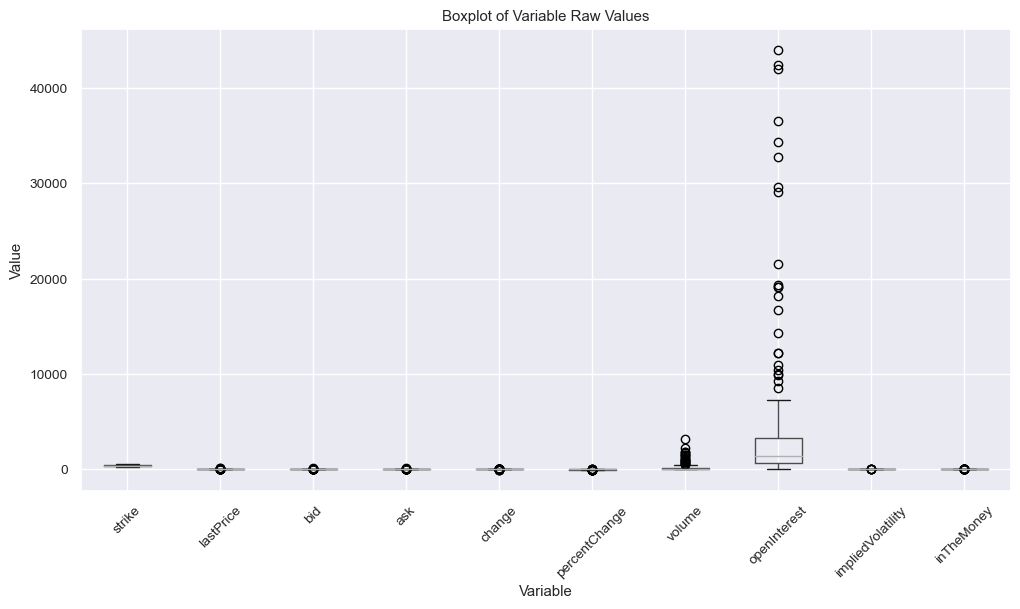

In [53]:
ax = put.boxplot(return_type='axes', rot=45, figsize=(12, 6))
ax.set_xlabel("Variable")
ax.set_ylabel("Value")
ax.set_title("Boxplot of Variable Raw Values")
plt.show()

In [54]:
put.describe()

,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility
count,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,175.000000,176.000000,176.000000
mean,402.000000,7.812955,7.557443,7.729773,-0.055341,-3.774733,218.982857,4327.073864,0.253816
std,57.503192,19.807114,19.174152,19.488108,1.458473,10.386457,457.196837,8143.166730,0.153031
min,270.000000,0.020000,0.020000,0.030000,-17.999998,-39.028618,1.000000,0.000000,0.096353
25%,357.750000,0.170000,0.137500,0.150000,-0.020000,-7.084411,5.000000,646.000000,0.137391
50%,401.500000,0.460000,0.425000,0.435000,0.000000,0.000000,26.000000,1463.000000,0.226265
75%,445.250000,3.527500,3.612500,3.622500,0.000000,0.000000,203.500000,3336.000000,0.327033
max,550.000000,112.780000,105.590000,107.020000,1.810001,12.694301,3165.000000,43976.000000,1.007970


In [55]:
#df_temp

In [56]:
aapl.options

('2023-11-21',
 '2023-11-22',
 '2023-11-24',
 '2023-11-27',
 '2023-11-28',
 '2023-11-29',
 '2023-11-30',
 '2023-12-01',
 '2023-12-08',
 '2023-12-15',
 '2023-12-22',
 '2023-12-29',
 '2024-01-19',
 '2024-02-16',
 '2024-03-15',
 '2024-03-28',
 '2024-06-21',
 '2024-06-28',
 '2024-09-20',
 '2024-09-30',
 '2024-12-20',
 '2025-01-17',
 '2025-03-21',
 '2025-06-20',
 '2025-12-19',
 '2026-01-16')

## Amazon  - Gabi in progress

In [57]:
# Download market data for Amazon: 

amzn = yf.Ticker("AMZN")
amzn.history_metadata

{'currency': 'USD',
 'symbol': 'AMZN',
 'exchangeName': 'NMS',
 'instrumentType': 'EQUITY',
 'firstTradeDate': 863703000,
 'regularMarketTime': 1700591452,
 'gmtoffset': -18000,
 'timezone': 'EST',
 'exchangeTimezoneName': 'America/New_York',
 'regularMarketPrice': 143.017,
 'chartPreviousClose': 145.8,
 'previousClose': 146.13,
 'scale': 3,
 'priceHint': 2,
 'currentTradingPeriod': {'pre': {'timezone': 'EST',
   'start': 1700557200,
   'end': 1700577000,
   'gmtoffset': -18000},
  'regular': {'timezone': 'EST',
   'start': 1700577000,
   'end': 1700600400,
   'gmtoffset': -18000},
  'post': {'timezone': 'EST',
   'start': 1700600400,
   'end': 1700614800,
   'gmtoffset': -18000}},
 'tradingPeriods':                                           pre_start                   pre_end  \
 Date                                                                            
 2023-11-14 00:00:00-05:00 2023-11-14 04:00:00-05:00 2023-11-14 09:30:00-05:00   
 2023-11-15 00:00:00-05:00 2023-11-15 04:00:0

In [58]:
# Import Amazon stock dataset: 

amzn = amzn.history(period="5y")
amzn_df = pd.DataFrame(amzn)

display(amzn_df.head(5))
display(amzn_df.tail(5))
display(amzn_df.describe())

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-11-21 00:00:00-05:00,77.149498,77.500000,75.750000,75.836502,114336000,0.0,0.0
2018-11-23 00:00:00-05:00,75.849998,76.809998,75.090500,75.102997,54152000,0.0,0.0
2018-11-26 00:00:00-05:00,76.949997,79.240501,76.210999,79.066498,125154000,0.0,0.0
2018-11-27 00:00:00-05:00,78.799500,79.882500,77.900497,79.070999,115664000,0.0,0.0
2018-11-28 00:00:00-05:00,80.695999,84.072502,80.060997,83.887497,169174000,0.0,0.0


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-11-15 00:00:00-05:00,147.059998,147.289993,142.589996,143.199997,63875700,0.0,0.0
2023-11-16 00:00:00-05:00,140.910004,143.320007,139.520004,142.830002,49653500,0.0,0.0
2023-11-17 00:00:00-05:00,142.660004,145.229996,142.539993,145.179993,49636700,0.0,0.0
2023-11-20 00:00:00-05:00,145.130005,146.630005,144.729996,146.130005,41951200,0.0,0.0
2023-11-21 00:00:00-05:00,143.910004,143.990005,141.500000,143.014496,49062717,0.0,0.0


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.0,1258.000000
mean,126.231752,127.792430,124.558898,126.190752,7.791918e+07,0.0,0.015898
std,31.907704,32.192705,31.533267,31.820445,3.532396e+07,0.0,0.563884
min,67.300003,69.801498,65.349998,67.197998,1.762600e+07,0.0,0.000000
25%,94.566248,95.619251,93.441250,94.598877,5.428785e+07,0.0,0.000000
50%,124.414997,126.364998,123.049252,124.755001,6.707655e+07,0.0,0.000000
75%,158.346878,159.930752,156.224998,158.093746,9.231600e+07,0.0,0.000000
max,187.199997,188.654007,184.839493,186.570496,3.113460e+08,0.0,20.000000


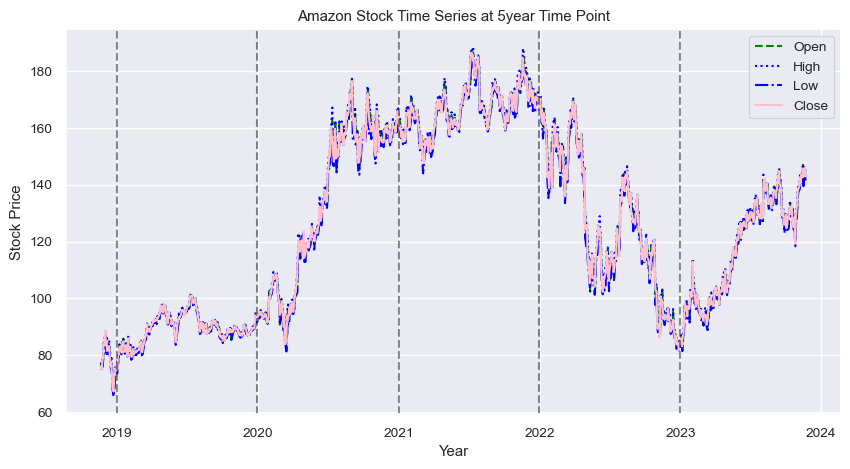

In [59]:
# Plot initial Amazon stock time series at 5y time point: 

plt.figure(figsize=(10, 5))
plt.plot(amzn_df['Open'], label='Open', color='green', linestyle='--')
plt.plot(amzn_df['High'], label='High', color='blue', linestyle='dotted')
plt.plot(amzn_df['Low'], label='Low', color='blue', linestyle='dashdot')
plt.plot(amzn_df['Close'], label='Close', color='pink')

for year in range(2019,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)

    
plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('Amazon Stock Time Series at 5year Time Point')
plt.legend()
plt.grid(True)
plt.show()

In [60]:
# Partition train and validation datasets: 

train = amzn_df.loc['2018-11-09':'2022-12-01']
train = train['Close'].asfreq('D')
amzn_train = train.ffill()

valid = amzn_df.loc['2022-12-02':'2023-11-08']

In [61]:
# Determine dataset stationarity: 
# H0 = time series not stationary; H1 = time series is stationary

result = adfuller(amzn_train )
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])
print('Time series is not stationary')

ADF Statistic: -1.595895
p-value: 0.485655
Critical Values:
{'1%': -3.434806296467238, '5%': -2.8635081624499494, '10%': -2.567817830533574}
Time series is not stationary


### STL Decoposition Using Locally Estimated Scatterplot Smoothing (LOESS)

In [62]:
# Fit close stock price dataset to STL: 

stl = STL(amzn_train, period=12)
result = stl.fit()


# Identify seasonal, trend, resid:

seasonal, trend, resid = result.seasonal, result.trend, result.resid

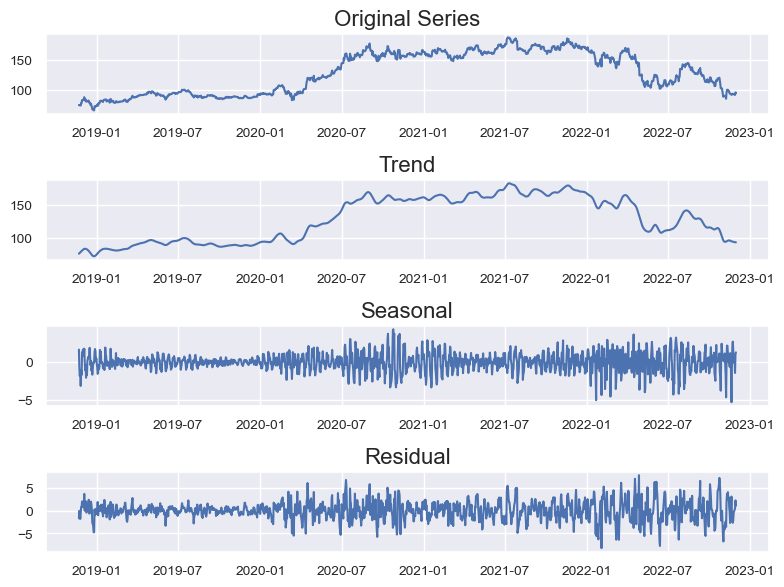

In [63]:
# Plot decomposition:

plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(amzn_train)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

### Holt's Winter Smoothing

In [64]:
# Looking at overall trend with Holt's Winter Smoothing

hw_model = ExponentialSmoothing(amzn_train,
                    trend='add', seasonal='add', seasonal_periods=4)
result_hw = hw_model.fit()

amzn_smo_fore = amzn_train.copy()
amzn_smo_fore['Forecast'] = result_hw.fittedvalues
amzn_smo_fore = pd.to_numeric(amzn_smo_fore, errors='coerce')
amzn_smo_fore.dropna(inplace=True)

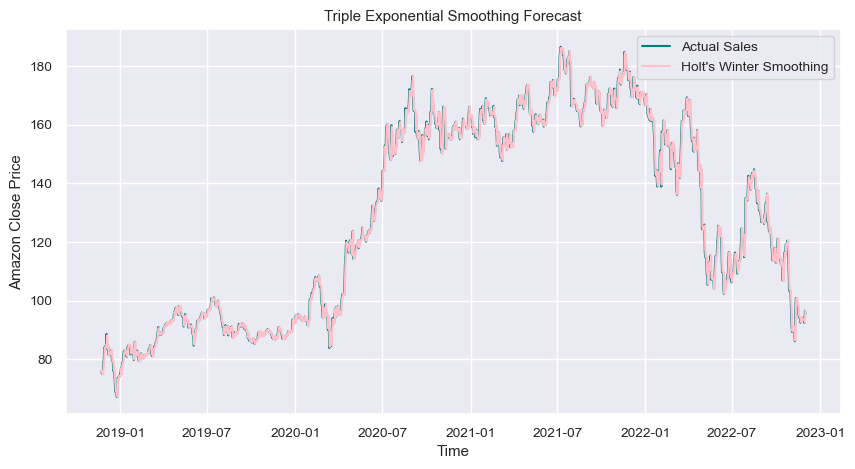

In [65]:
# Plot Holt's Winter Smoothing:

plt.figure(figsize=(10, 5))
plt.plot(amzn_smo_fore, label='Actual Sales', color = 'Teal', marker='')
plt.plot(result_hw.fittedvalues, label="Holt's Winter Smoothing", color = 'pink')
plt.xlabel('Time')
plt.ylabel('Amazon Close Price')
plt.title('Triple Exponential Smoothing Forecast')
plt.legend()
plt.show()

### Anomaly Detection

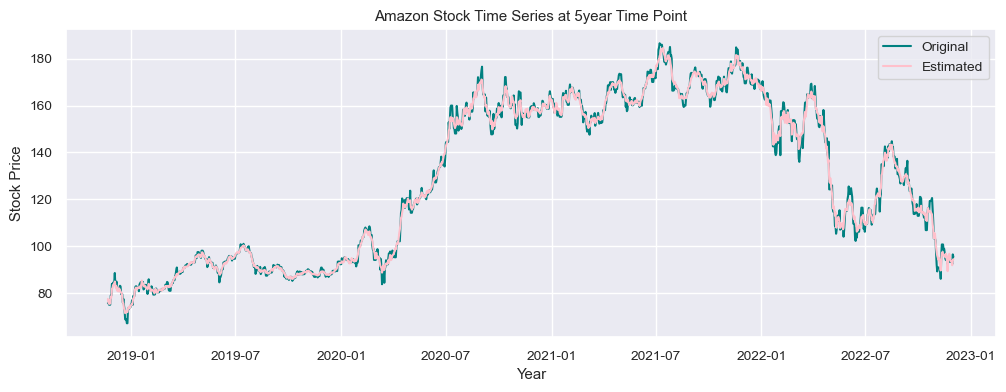

In [66]:
# Plot original Amazon Close time series vs Forecasted time series: 

estimated = trend + seasonal
plt.figure(figsize=(12,4))
plt.plot(amzn_train, label='Original', color = 'teal')
plt.plot(estimated, label ='Estimated', color = 'pink')

plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('Amazon Stock Time Series at 5year Time Point')
plt.legend()
plt.grid(True)
plt.show()

In [67]:
# Taking residuals and detecting anomaly at 3std. dev: 

resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev

(17775.0, 19358.0)

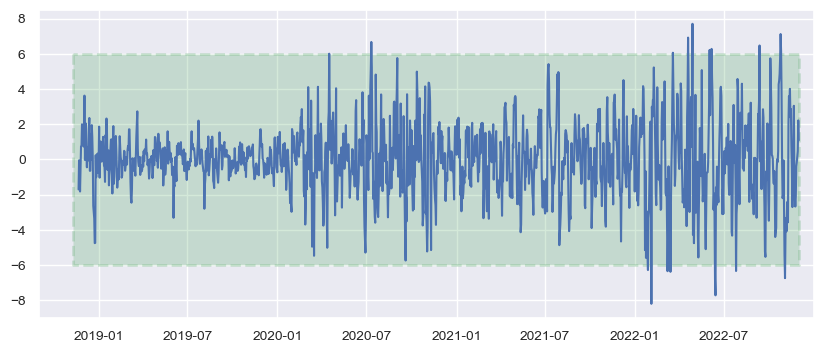

In [68]:
# Plot residual threshold: 

plt.figure(figsize=(10,4))
plt.plot(resid)

plt.fill_between([datetime(2018,11,9), datetime(2022,12,1)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.xlim(datetime(2018,9,1), datetime(2023,1,1))

In [69]:
# Identify anomalies by setting the residuals upper and lower limits:

anomalies = amzn_train[(resid < lower) | (resid > upper)]
anomalies = pd.DataFrame(anomalies)

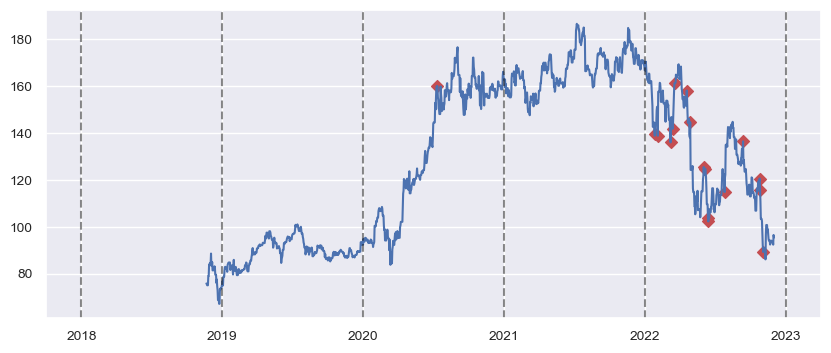

In [70]:
# Plot identified residual anomalies:    ********In Progress*******

plt.figure(figsize=(10,4))
plt.plot(amzn_train)

for year in range(2018,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)
    
plt.scatter(anomalies.index, anomalies.Close, color='r', marker='D')

In [71]:
# Anomalies identified outside 3std dev of residuals: 

anomalies.head()

,Close
Date,
2020-07-11 00:00:00-04:00,160.000000
2022-01-27 00:00:00-05:00,139.637497
2022-02-03 00:00:00-05:00,138.845505
2022-03-08 00:00:00-05:00,136.014496
2022-03-14 00:00:00-04:00,141.852997


### Transforming Time Series to Stationary

Text(0, 0.5, 'Amazon Stock Closing Price \n(First Diff.)')

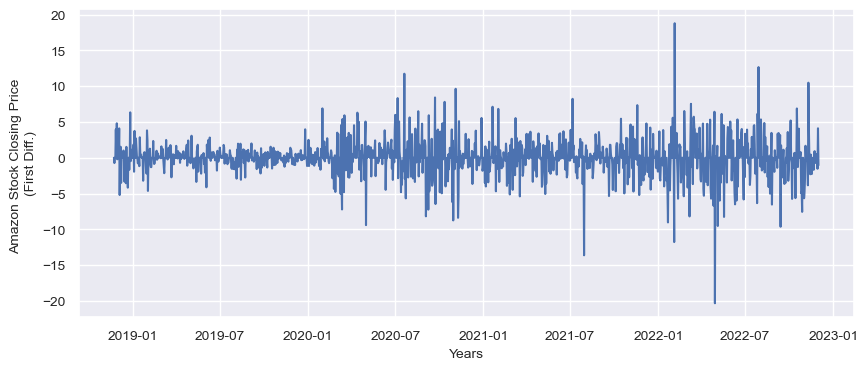

In [72]:
# Removing trend by applying the first Difference: 

diff_ts = amzn_train.diff().dropna()

# Plot first difference: 

plt.figure(figsize=(10,4))
plt.plot(diff_ts)

plt.xlabel('Years', fontsize=10)
plt.ylabel('Amazon Stock Closing Price \n(First Diff.)', fontsize=10)

In [73]:
# Determine dataset stationarity: 
# H0 = time series not stationary; H1 = time series is stationary

result = adfuller(diff_ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])
print('Time series is stationary')

ADF Statistic: -40.177401
p-value: 0.000000
Critical Values:
{'1%': -3.434806296467238, '5%': -2.8635081624499494, '10%': -2.567817830533574}
Time series is stationary


### Selecting a Model

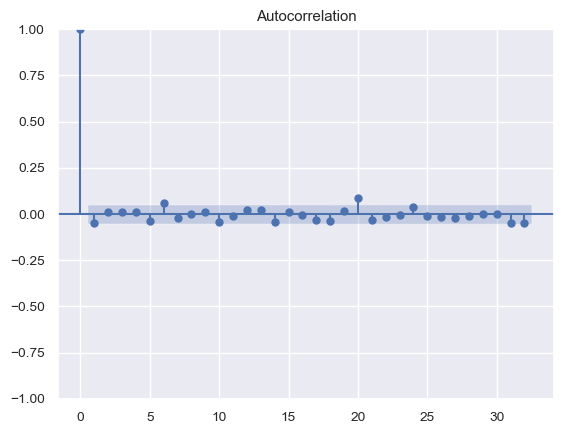

None

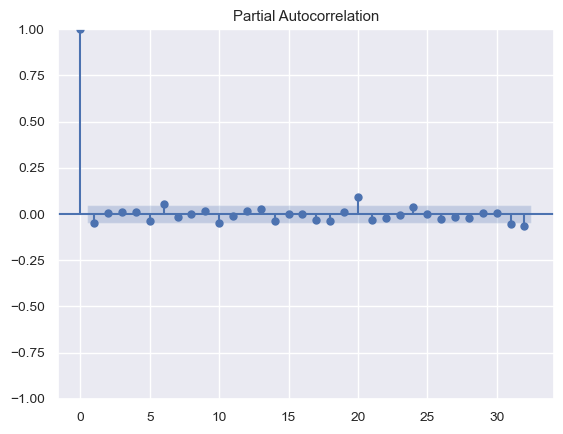

None

In [74]:
# ACF suggest MA Lag 1 

plot_acf(diff_ts)
display(plt.show())

# PACF suggest AR Lag 1

plot_pacf(diff_ts, method='ywm')
display(plt.show())

#### Model Selection Criteria: 

>BIC = $\ln(n)k$ - 2$l$
>
>AIC = 2$k$ - 2$l$


>($l$) = a log likelihood 
>
>($k$) = a number of parameters 
>
>($n$) = a number of samples used for fitting


In [75]:
# Auto ARIMA Model: 
# p = number of lag observations, lag order
# d = number of raw observations differenced, degree of differencing
# q = size of moving average window, order of moving average

auto_arima_model = auto_arima(diff_ts, d=1, seasonal=True, stepwise=True, trace=True)
auto_arima_model.summary()

val_close = valid['Close'].asfreq('D')
arima_pred = auto_arima_model.predict(n_periods=len(val_close))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7872.767, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7395.847, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7870.767, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7210.314, Time=0.36 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=7109.951, Time=0.45 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=7071.571, Time=0.60 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=7001.133, Time=0.61 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.28 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.59 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=6999.134, Time=0.30 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=7069.572, Time=0.25 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=1.41 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=1.35 s

In [76]:
# ARIMA Model and Forecast at ARIMA(5,1,0): 

arima_m = sm.tsa.ARIMA(diff_ts, order=(5,1,0)).fit() 
print(arima_m.summary())

arima_pred = arima_m.forecast(steps=len(val_close))

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1471
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3493.567
Date:                Tue, 21 Nov 2023   AIC                           6999.134
Time:                        10:31:31   BIC                           7030.892
Sample:                    11-22-2018   HQIC                          7010.977
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8785      0.018    -49.688      0.000      -0.913      -0.844
ar.L2         -0.7035      0.024    -28.787      0.000      -0.751      -0.656
ar.L3         -0.5266      0.029    -18.136      0.0

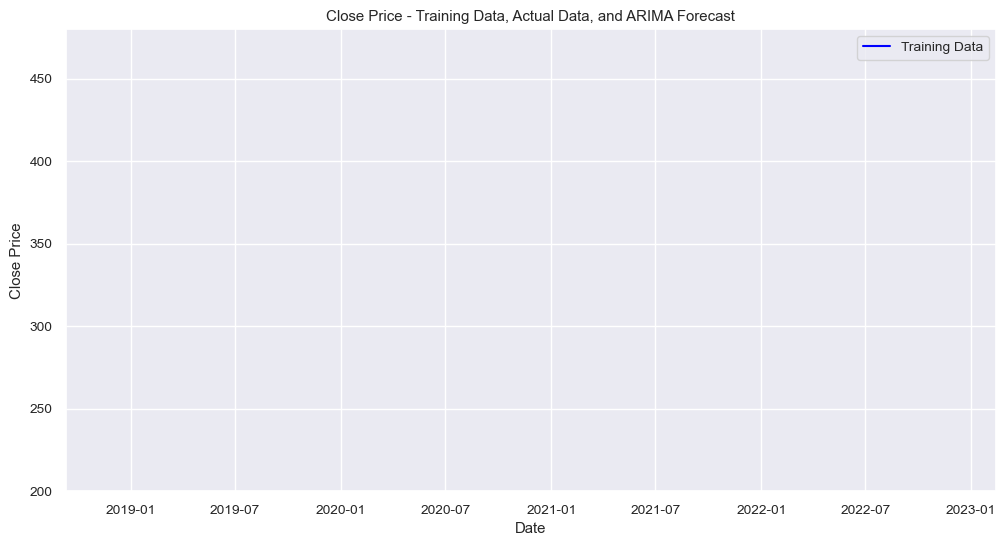

In [77]:
# plt.plot(close_valid.index, arima_pred, label="Predicted", color='red')

plt.figure(figsize=(12,6))
ax = plt.gca()
ax.set_ylim([200, 480])
plt.plot(diff_ts, label='Training Data', color='blue')
#plt.plot(arima_m.fittedvalues, label="Model", color = 'orange') 
#plt.plot(val_close, label='Actual Data (Validation)', color='green', linestyle='--')
#plt.plot(val_close.index, arima_pred, label='ARIMA Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

###### Code References: 
    
 https://github.com/ritvikmath/Time-Series-Analysis/blob/master/STL%20Decomposition.ipynb   
    